In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества
from sklearn.metrics import accuracy_score

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F
import gc
import os
import time
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import seaborn as sns
import matplotlib

In [ ]:
# device = torch.device('cpu')
device = torch.device('cuda')

## Загрузка и подготовка данных

In [ ]:
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/U2oKF_GhlAV8zg

--2022-11-10 08:47:17--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/U2oKF_GhlAV8zg
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/d3da083ab251a2f3ea8d2e01b61de4d2b351a92c33d352df661d43fe8cf9a6f4/636cea51/0XwX0v46-8z48XQkrFJJQ5eHUzJKT9xcdnJ3VUz3tiKme-vC5AubF1Xh1CW8UOvX3R7m9HayHH2ppVWVc9xRIA%3D%3D?uid=0&filename=archive%20%284%29.zip&disposition=attachment&hash=yaMXz/lQ1Ujf05GgWsLfYmNmQCDmb3mTXz39bX97bx4ChjOXooUt6JFHXi0Umg%2Bbq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=491384048&fsize=729700755&hid=2c8b7f82da1edd6fbaf029debc156e9f&media_type=compressed&tknv=v2 [following]
--2022-11-10 08:47:17--  https://downloader.disk.yandex.ru/disk/d3da083ab251a2f3ea8d2e01b61de4d2b351a92c33d352df661d43fe8cf9a6f4/636cea51/0XwX0v46-8z48XQkrF

In [ ]:
!unzip U2oKF_GhlAV8zg

In [ ]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
         transforms.Resize((64, 64)),
         transforms.AutoAugment(),
         transforms.ToTensor(),
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((64, 64)),
         transforms.ToTensor(),
])

In [ ]:
# при загрузке сразу указываем как предобрабатывать
train_data = datasets.ImageFolder("afhq/train/", transform=transform_train)
test_data = datasets.ImageFolder("afhq/val", transform=transform_val)
# там же в transforms с версии торча 1.8+ появилась и аугментация

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: afhq/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
               ToTensor()
           )

In [ ]:
# разбиваем сразу на батчи (обычно берут под максимум, который влезает в память)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle = False, pin_memory=True, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
# размер картинок
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [ ]:
ntn = {
    0: "Cat",
    1: "Dog",
    2: "Wild"
}

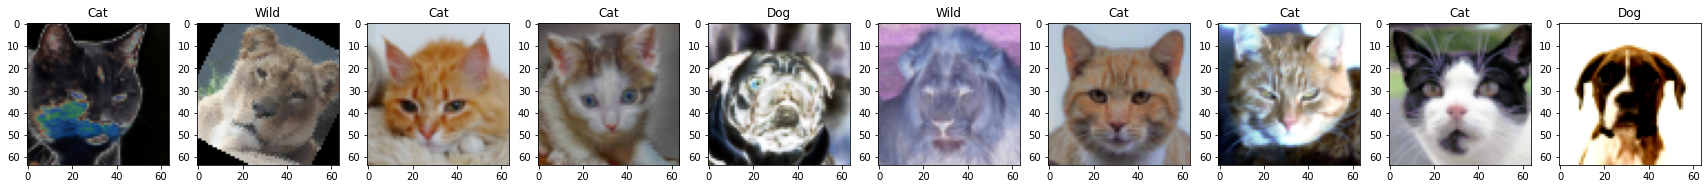

In [ ]:
# посмотрим на пару из них
ddata = 0
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i+ddata].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(ntn[int(labels[i+ddata].numpy())])
    plt.show()

show_imgs(images, labels)

## Полносвязная сеть

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(64*64*3, 64*64) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(64*64, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# 14630 / 2 = 7315
# 14630 / 4 = 3657.5
# 14630 / 16 = 914.37
# всего 14630 / 32 = 457.18 батчей
# всего 14630 / 128 = 114.29 батчей

def train(net, optimizer, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()
    n_loss = 25
    n_acc = 50

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if (i % n_acc) == (n_acc-1):
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if (i % n_loss) == (n_loss - 1):
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / n_loss))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
torch.cuda.empty_cache()
gc.collect()

22040

In [ ]:
# объявляем сеть
net = SimpleNet().to(device)
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
learning_rate = 1e-3
opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
net = train(net, opt, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

[1,    25] loss: 2.435
New best model with test acc: 0.5146059782608695
[1,    50] loss: 1.078
[1,    75] loss: 1.044
New best model with test acc: 0.6237545289855072
[1,   100] loss: 0.998


  0%|          | 0/115 [00:00<?, ?it/s]

[2,    25] loss: 0.975
[2,    50] loss: 0.954
[2,    75] loss: 0.935
New best model with test acc: 0.6747056159420289
[2,   100] loss: 0.887


  0%|          | 0/115 [00:00<?, ?it/s]

[3,    25] loss: 0.867
New best model with test acc: 0.7059273097826088
[3,    50] loss: 0.862
[3,    75] loss: 0.855
New best model with test acc: 0.7374603713768115
[3,   100] loss: 0.826


  0%|          | 0/115 [00:00<?, ?it/s]

[4,    25] loss: 0.825
New best model with test acc: 0.7735790307971014
[4,    50] loss: 0.800
[4,    75] loss: 0.776
[4,   100] loss: 0.810


  0%|          | 0/115 [00:00<?, ?it/s]

[5,    25] loss: 0.789
[5,    50] loss: 0.755
[5,    75] loss: 0.756
[5,   100] loss: 0.731
Обучение закончено


In [ ]:
nlist = ['Cat', 'Dog', 'Wild']
yle = LabelEncoder()
yle.fit_transform(nlist)
yle.classes_

array(['Cat', 'Dog', 'Wild'], dtype='<U4')

In [ ]:
def ShowHeat(y_pred, y_real):
    sns.set(font_scale=1.25)

    fig = plt.figure(figsize=(6,4))
    nn_mtx = metrics.confusion_matrix(y_real, y_pred)
    font = {'weight' : 'bold', 'size'   :22}
    matplotlib.rc('xtick', labelsize=18)
    matplotlib.rc('ytick', labelsize=18)
    sns.heatmap(nn_mtx, annot=True, fmt="d",
                xticklabels=nlist,
                yticklabels=nlist,
                cmap='coolwarm', vmin=0, cbar=False)
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")
    plt.show()
    print(metrics.classification_report(yle.inverse_transform(y_real), yle.inverse_transform(y_pred)))

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.to(device)).detach().cpu().numpy())

In [ ]:
len(labels_net), len(labels_true)

(1500, 1500)

In [ ]:
labels_net

In [ ]:
# acc_score на test
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.7553333333333333

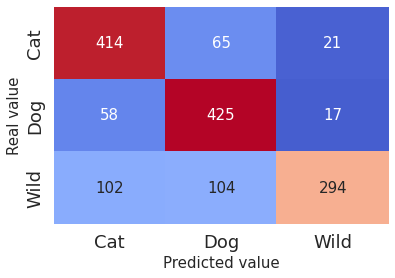

              precision    recall  f1-score   support

         Cat       0.72      0.83      0.77       500
         Dog       0.72      0.85      0.78       500
        Wild       0.89      0.59      0.71       500

    accuracy                           0.76      1500
   macro avg       0.77      0.76      0.75      1500
weighted avg       0.77      0.76      0.75      1500



In [ ]:
ShowHeat(np.argmax(np.array(labels_net), axis=1), labels_true)

## Сверточная сеть

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 3, kernel_size=3)
        self.flatten = Flatten()
        self.fc = nn.Linear(10800, 3) # какой тут будет размер входа? не всегда очевидно, особенно когда слоев много и этапов много, пробуйте выводить x.size() при прямом проходе

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        # print(x.size())
        x = self.fc(x)
        # print(x.shape)
        return x

In [ ]:
torch.cuda.empty_cache()
gc.collect()

177

In [ ]:
cnet = ConvNet().to(device)
opt = torch.optim.Adam(cnet.parameters(), lr=learning_rate)
cnet = train(cnet, opt, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

[1,    25] loss: 1.098
New best model with test acc: 0.5743319746376812
[1,    50] loss: 1.048
[1,    75] loss: 0.927
New best model with test acc: 0.6793478260869565
[1,   100] loss: 0.801


  0%|          | 0/115 [00:00<?, ?it/s]

[2,    25] loss: 0.689
New best model with test acc: 0.7944972826086957
[2,    50] loss: 0.667
[2,    75] loss: 0.625
New best model with test acc: 0.8192651721014492
[2,   100] loss: 0.600


  0%|          | 0/115 [00:00<?, ?it/s]

[3,    25] loss: 0.567
New best model with test acc: 0.8334182518115942
[3,    50] loss: 0.565
[3,    75] loss: 0.551
New best model with test acc: 0.8499490489130435
[3,   100] loss: 0.541


  0%|          | 0/115 [00:00<?, ?it/s]

[4,    25] loss: 0.502
New best model with test acc: 0.8547610960144928
[4,    50] loss: 0.485
[4,    75] loss: 0.485
New best model with test acc: 0.8757076539855072
[4,   100] loss: 0.492


  0%|          | 0/115 [00:00<?, ?it/s]

[5,    25] loss: 0.448
[5,    50] loss: 0.477
[5,    75] loss: 0.463
[5,   100] loss: 0.438
Обучение закончено


In [ ]:
labels_cnet = []
for images, labels in test_loader:
    labels_cnet.extend(cnet.forward(images.to(device)).detach().cpu().numpy())

In [ ]:
len(labels_cnet), len(labels_true)

(1500, 1500)

In [ ]:
# acc_score на test
accuracy_score(labels_true, np.argmax(np.array(labels_cnet), axis=1))

0.8646666666666667

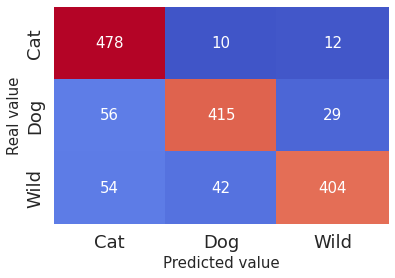

              precision    recall  f1-score   support

         Cat       0.81      0.96      0.88       500
         Dog       0.89      0.83      0.86       500
        Wild       0.91      0.81      0.86       500

    accuracy                           0.86      1500
   macro avg       0.87      0.86      0.86      1500
weighted avg       0.87      0.86      0.86      1500



In [ ]:
ShowHeat(np.argmax(np.array(labels_cnet), axis=1), labels_true)

- судя по логам обучения нейросетей (по количеству батчей) AutoAugment не увеличивает количество примеров...а выборочно преобразует и заменяет существующие
- на удивление хорошее качество дает даже обычная полносвязная сеть, ошибаясь значительно только в классе "Wild".
- сверточная сеть работает, ожидаемо, еще существенно лучше.